Team,

I've produced clean data for folks to work with downstream, and provided some preliminary sketches of how the data can be used.  Scan thru the notebook to see what the dataframes look like....

<b>youtube_data</b>: US data downloaded from youtube and cleaned<br><br>
<b>pub_by_date</b>: Videos published by date.  I made a line graph. I can also group them by day of week if you'd like.<br><br>
<b>categories</b>: Vids grouped by category with number, likes and dislikes.  Can make plots / inferences.<br><br>
<b>month_stats</b>: Data by months--published, trending, views<br><br>
<b>lag_data</b>: days it takes videos to trend.  Nice histogram with single outlier that we could find and remove.

I've also done the user input thing at the end.

Most of the work was brute-force data cleaning, and therefore not very interesting.  However, some learning:

<i>1) The datetime type allows you to manipulate dates with ease.  Not covered in class but powerful.  See the description in cell In[4].</i><br><br>
<i>2) Lots of duplicate videos.  Folks post the same video multiple times from the same account.  Dropped these.  If I want to be more sophisticated, I'd loop thru videos by name, and total all of the video statistics for all repeats.  Maybe will do that this week to further clean up the data.</i>

Let me know if there is other data you'd like me to produce.  I'll start helping with the MatPlotLib and API folks now.

--Tom


In [1]:
%matplotlib notebook
%matplotlib inline 

In [2]:
# Load packages
from matplotlib import pyplot as plt
from scipy.stats import linregress
import numpy as np; np.random.seed(1)
from sklearn import datasets
import pandas as pd
import functools as ft
import seaborn as sns
import re  
from scipy.stats import logistic
import calendar
import random

In [3]:
# Load data
youtube_data = pd.read_csv('US_youtube_trending_data.csv')
lookup = pd.read_csv('category_ids.csv')
df2020 = pd.read_csv('clean_data_20.csv')


In [4]:
# Function to parse dates (there is probably a built-in function, but this is what I was able to figure out)

def youtube_date_parse(df, series_to_parse, new_name_date, new_name_time, delimiting_character, drop_character):
    try:
        split = df[series_to_parse].str.split(delimiting_character, n = 1, expand = True)
        split[1] =split[1].map(lambda x: x.rstrip(drop_character))
        df[new_name_date] = split[0]
        df[new_name_time] = split[1]
        df.drop(columns = [series_to_parse], inplace=True)
        df[new_name_date] = pd.to_datetime(df[new_name_date])
        return df
    except:
        print('Already parsed, dumbass...')
        
        

In [5]:
########### Clean up data: drop columns, parse dates, replace category numbers with cateogry names, etc. #####

# Drop unneeded columns
youtube_data.drop(['video_id','channelId', 'thumbnail_link', 'comments_disabled', 'ratings_disabled'],\
                  axis=1, inplace = True)

# Convert date strings to datetime objects
youtube_date_parse(youtube_data, 'publishedAt', 'date_published', 'time_published', 'T', 'Z')
youtube_date_parse(youtube_data, 'trending_date', 'date_trending', 'time_trending', 'T', 'Z')
youtube_data.drop(['time_trending'], axis=1, inplace=True)

# The datetime functions are great, and can be used to group (see below).
# To make life easier for folks, I'm going to put month names in their own column
# notice the .dt.month syntax that works on datetime objects
youtube_data['month_published']= youtube_data['date_published'].dt.month
youtube_data['month_trending'] = youtube_data['date_trending'].dt.month
youtube_data['month_published'].replace([8,9,10,11], ['Aug', 'Sept', 'Oct', 'Nov'], inplace=True)
youtube_data['month_trending'].replace([8,9,10,11], ['Aug', 'Sept', 'Oct', 'Nov'], inplace=True)

# Calculate lag time between posting and trending.  You can do arithmetic with dates in datetime
youtube_data['lag'] = youtube_data['date_trending'] - youtube_data['date_published']

# Covert category IDs to catetory names
youtube_data['categoryId'].replace(lookup['categoryId'].tolist(), lookup['category'].tolist(), inplace=True)

# Rename columns
new_names = {'channelTitle':'channel', 'categoryId':'category', 'view_count':'views', 'comment_count':'comments'}
youtube_data.rename(columns = new_names, inplace=True)

# Sort by likes
youtube_data.sort_values('likes', ascending=False, inplace=True)


# Reorder columns for readability
new_order = ['channel', 'title', 'category', 'views', 'likes','dislikes','comments', 'date_published', 'date_trending','lag','month_published', 'month_trending', 'time_published','tags', 'description']
youtube_data=youtube_data[new_order]

# Get column names so they are handy
cols = youtube_data.columns

# Keep only the most popular posting of duplicate videos
# I could maybe try to roll the stats for duplicates together,
# but this is tricky, in that they will have different dates.
youtube_data = youtube_data.drop_duplicates(subset='title', keep='first')
youtube_data.head()


,channel,title,category,views,likes,dislikes,comments,date_published,date_trending,lag,month_published,month_trending,time_published,tags,description
3358,Big Hit Labels,BTS (방탄소년단) 'Dynamite' Official MV,Music,232649205,15735533,714194,6065230,2020-08-21,2020-08-28,7 days,Aug,Aug,03:58:10,BIGHIT|빅히트|방탄소년단|BTS|BANGTAN|방탄,BTS (방탄소년단) 'Dynamite' Official MVCredits:Dire...
4980,BLACKPINK,BLACKPINK - 'Ice Cream (with Selena Gomez)' M/V,Music,184778248,11795670,879354,2735997,2020-08-28,2020-09-05,8 days,Aug,Sept,04:00:11,YG Entertainment|YG|와이지|K-pop|BLACKPINK|블랙핑크|블...,BLACKPINK - ‘Ice Cream (with Selena Gomez)’Com...
11764,BLACKPINK,BLACKPINK – ‘Lovesick Girls’ M/V,Music,140685439,9217876,127308,1507605,2020-10-02,2020-10-09,7 days,Oct,Oct,04:00:13,YG Entertainment|YG|와이지|K-pop|BLACKPINK|블랙핑크|블...,BLACKPINK – ‘Lovesick Girls’영원한 밤창문 없는 방에 우릴 가...
2762,Big Hit Labels,BTS (방탄소년단) 'Dynamite' Official Teaser,Music,62496726,6178664,158845,992356,2020-08-18,2020-08-25,7 days,Aug,Aug,15:00:02,BIGHIT|빅히트|방탄소년단|BTS|BANGTAN|방탄,BTS (방탄소년단) 'Dynamite' Official TeaserBTS (방탄소...
3992,Big Hit Labels,BTS (방탄소년단) 'Dynamite' Official MV (B-side),Music,45596902,5951286,97683,382374,2020-08-24,2020-08-31,7 days,Aug,Aug,15:00:01,BIGHIT|빅히트|방탄소년단|BTS|BANGTAN|방탄,BTS (방탄소년단) 'Dynamite' Official MV (B-side)Cre...


In [6]:
# See how many videos were published each day in the dataset
# Remember, the youtube data set is a subset of of trending videos in the US, not all videos
pub_by_date = youtube_data[['title', 'date_published']].groupby('date_published')\
.count().rename(columns={'title':'number_published'})
pub_by_date

,number_published
date_published,
2020-08-03,1
2020-08-05,4
2020-08-06,22
2020-08-07,34
2020-08-08,29
...,...
2020-11-01,27
2020-11-02,38
2020-11-03,13


(array([737638., 737652., 737669., 737683., 737699., 737713., 737730.]),
 <a list of 7 Text major ticklabel objects>)

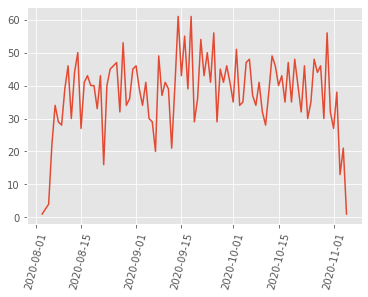

In [7]:
# And plot the number published each day
# I could see if there are trends by days of the week
plt.style.use('ggplot')
plt.plot(pub_by_date['number_published'])
plt.xticks(rotation=75)

In [8]:
# Categories looks at total published, likes, and dislikes.
# Only the news and politics have significant dislikes
categories = youtube_data[['category', 'title']].groupby('category').count().rename(columns={'title':'number_published'}).sort_values('number_published', ascending=False)


categories['likes'] = youtube_data[['category', 'likes']].groupby('category').sum()
categories['dislikes'] = youtube_data[['category', 'dislikes']].groupby('category').sum()
#opinions = pd.merge(likes, dislikes, on="category")

categories['total_opinions'] = categories['likes'] + categories['dislikes'] 
categories['% like'] = (categories['likes'] / categories['total_opinions']).map("{:.2%}".format)
categories['% dislike'] = (categories['dislikes'] / categories['total_opinions']).map("{:.2%}".format)

print('categories:')
categories

categories:


,number_published,likes,dislikes,total_opinions,% like,% dislike
category,,,,,,
Music,801,254239406,6688126,260927532,97.44%,2.56%
Entertainment,657,103303685,2091086,105394771,98.02%,1.98%
Sports,504,15862292,569669,16431961,96.53%,3.47%
Gaming,317,47113552,1322594,48436146,97.27%,2.73%
People & Blogs,273,36294827,1085630,37380457,97.10%,2.90%
Comedy,212,29566307,340045,29906352,98.86%,1.14%
Science & Technology,180,15725993,597019,16323012,96.34%,3.66%
News & Politics,158,3223871,556373,3780244,85.28%,14.72%
Howto & Style,151,11417546,347035,11764581,97.05%,2.95%


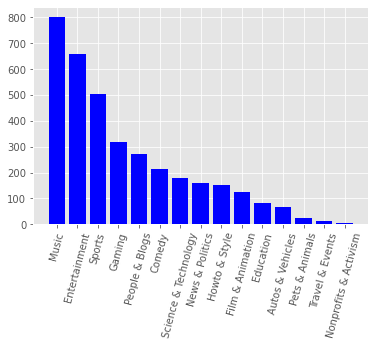

In [9]:
# Plot number of vids in each category
# Someone could add the x labels.  I'm bad at it.
plt.style.use('ggplot')
x_axis = categories.index
y_axis = categories['number_published']
plt.bar(x_axis, y_axis, color='b' )
plt.xticks(rotation=75)
plt.show()

In [10]:
# See if there are any trends by month.
# There are not.

month_stats = youtube_data[['date_published', 'title']].groupby(pd.Grouper(key='date_published',freq='M')).count()\
.rename(columns={'title':'published'})
month_stats['trending'] = youtube_data[['date_trending', 'title']].groupby(pd.Grouper(key='date_trending',freq='M')).count()
month_stats['views'] = youtube_data[['date_published', 'views']].groupby(pd.Grouper(key='date_published',freq='M')).sum()
print('month_stats:')
month_stats.set_index(pd.Index(['Aug', 'Sept', 'Oct', 'Nov']))

month_stats:


,published,trending,views
Aug,988,783,2942488874
Sept,1236,1221,3239138144
Oct,1242,1239,3753111791
Nov,100,323,172017030


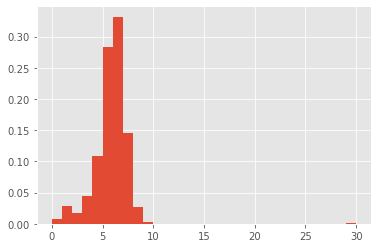

In [11]:
# See how long it takes a video to trend.
# We have a single outlier at 30 days, which we could chop off in subsequent work.
plt.style.use('ggplot')
lag_data = youtube_data['lag'].dt.days
plt.hist(lag_data, density=True, bins=30)
plt.show()

# Produce the most popular videos for a user

answer = 'Y'
while answer == 'Y':
    month = input('\n\nMonth for most liked videos (Aug, Sept, Oct, Nov)?')
    number = int(input('How many videos to see?'))
    month_data = youtube_data.loc[youtube_data['month_published']==month]
    month_sorted = month_data.sort_values('likes', ascending=False)
    print('Most popular videos:')
    vids = month_sorted.iloc[0:number,:]
    print(vids['title'])
    answer = input('Continue Y/N?')

In [12]:
#William's code
#Coorelation between youtube scrubbed dat
youtube_coor = youtube_data.corr()
print(youtube_coor)

             views     likes  dislikes  comments
views     1.000000  0.900376  0.796866  0.727448
likes     0.900376  1.000000  0.776946  0.763612
dislikes  0.796866  0.776946  1.000000  0.724846
comments  0.727448  0.763612  0.724846  1.000000


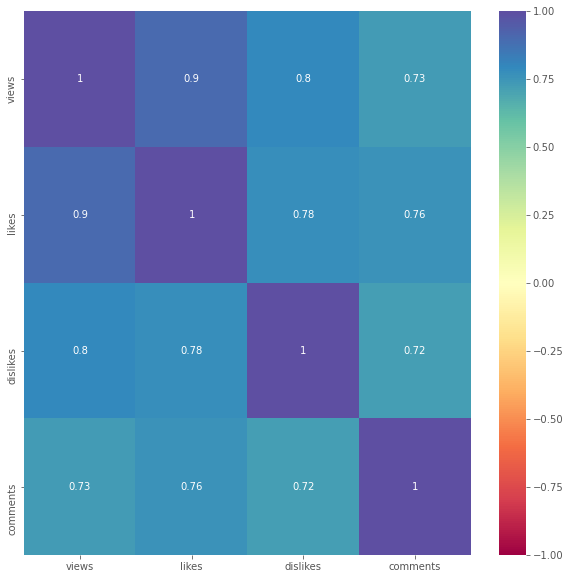

In [13]:
#Coorelation heatmap using Seaborn
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(youtube_coor,annot=True,vmin=-1,vmax=1,cmap="Spectral")
plt.show()

In [14]:
#Extract Channel Views by Trending Month
channels = youtube_data[['channel','views','month_trending']]
channels.reset_index(drop=True,inplace=True)
channel_uni = channels.drop_duplicates(subset='channel', keep='first')
channel_uni.sort_values('month_trending')
channel_uni.reset_index(drop=True)
channel_ind = channel_uni.set_index("channel")
channel_ind

,views,month_trending
channel,,
Big Hit Labels,232649205,Aug
BLACKPINK,184778248,Sept
BANGTANTV,38303194,Oct
Cardi B,98442414,Aug
ArianaGrandeVevo,47606296,Oct
...,...,...
The Weather Channel,236596,Aug
THE BOYZ,5981959,Sept
CONMEBOL,1304470,Oct


In [15]:
#Classify Top Trending Channels by Month for August
aug_channels = channel_ind.loc[channel_ind["month_trending"] == "Aug"]
aug_scrub = aug_channels.nlargest(10,'views')
print(aug_scrub)
aug_scrub.head()

                           views month_trending
channel                                        
Big Hit Labels         232649205            Aug
Cardi B                 98442414            Aug
Ozuna                   45893190            Aug
DrakeVEVO               45086708            Aug
MileyCyrusVEVO          42667486            Aug
KQ ENTERTAINMENT        30059975            Aug
Nike                    29422403            Aug
ElAlfaElJefeTV          20288733            Aug
TREASURE (트레저)          19682753            Aug
Warner Bros. Pictures   19666039            Aug


,views,month_trending
channel,,
Big Hit Labels,232649205,Aug
Cardi B,98442414,Aug
Ozuna,45893190,Aug
DrakeVEVO,45086708,Aug
MileyCyrusVEVO,42667486,Aug


In [16]:
#Classify Top Trending Channels by Month for September
sept_channels = channel_ind.loc[channel_ind["month_trending"] == "Sept"]
sept_scrub = sept_channels.nlargest(10,'views')
print(sept_scrub)
sept_scrub.head()

                                        views month_trending
channel                                                     
BLACKPINK                           184778248           Sept
DJKhaledVEVO                         43394819           Sept
Stone Music Entertainment            41213361           Sept
J97                                  37422074           Sept
Brawl Stars                          32114735           Sept
MTV                                  29442683           Sept
Sech                                 28625426           Sept
CamiloVEVO                           26515286           Sept
CLC 씨엘씨 (Official YouTube Channel)   24613217           Sept
Daddy Yankee                         23452671           Sept


,views,month_trending
channel,,
BLACKPINK,184778248,Sept
DJKhaledVEVO,43394819,Sept
Stone Music Entertainment,41213361,Sept
J97,37422074,Sept
Brawl Stars,32114735,Sept


In [17]:
#Classify Top Trending Channels by Month for October
oct_channels = channel_ind.loc[channel_ind["month_trending"] == "Oct"]
oct_scrub = oct_channels.nlargest(10,'views')
print(oct_scrub)
oct_scrub.head()

                        views month_trending
channel                                     
The Pixel Kingdom    73728043            Oct
JustinBieberVEVO     57463872            Oct
SMTOWN               56531571            Oct
Apple                53596388            Oct
ArianaGrandeVevo     47606296            Oct
Zee Music Company    44649281            Oct
BANGTANTV            38303194            Oct
KarolGVEVO           23955265            Oct
Saturday Night Live  23841894            Oct
Hornstromp Games     23171453            Oct


,views,month_trending
channel,,
The Pixel Kingdom,73728043,Oct
JustinBieberVEVO,57463872,Oct
SMTOWN,56531571,Oct
Apple,53596388,Oct
ArianaGrandeVevo,47606296,Oct


In [18]:
#Classify Top Trending Channels by Month for November
nov_channels = channel_ind.loc[channel_ind["month_trending"] == "Nov"]
nov_scrub = nov_channels.nlargest(10,'views')
print(nov_scrub)
nov_scrub.head()

                      views month_trending
channel                                   
JYP Entertainment  74991178            Nov
Bad Bunny          39597322            Nov
Fox News           33067375            Nov
HarryStylesVEVO    32844931            Nov
NBC News           27255331            Nov
League of Legends  26787567            Nov
Myke Towers        22287766            Nov
James Charles      19348499            Nov
starshipTV         11590334            Nov
Marques Brownlee   10374991            Nov


,views,month_trending
channel,,
JYP Entertainment,74991178,Nov
Bad Bunny,39597322,Nov
Fox News,33067375,Nov
HarryStylesVEVO,32844931,Nov
NBC News,27255331,Nov


Text(0.5, 0, 'Channel')

C:\Users\citiz\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 53944 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\citiz\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 47112 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\citiz\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 51200 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\citiz\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 53944 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\citiz\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 47112 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\citiz\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 51200 missing from curre

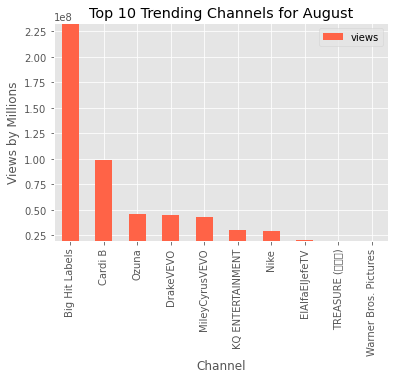

In [19]:
#Graph August
plt.style.use('ggplot')
aug_scrub.head(10).plot(kind="bar",facecolor="tomato")
aug_top = aug_scrub['views'].max()
aug_bottom = aug_scrub['views'].min()
aug_x_axis = aug_scrub.index
aug_y_axis = aug_scrub['views']
plt.ylim(aug_bottom,aug_top)
plt.title("Top 10 Trending Channels for August")
plt.ylabel("Views by Millions")
plt.xlabel("Channel")

Text(0.5, 0, 'Channel')

C:\Users\citiz\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 50472 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\citiz\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 50648 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\citiz\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 50472 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\citiz\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 50648 missing from current font.
  font.set_text(s, 0, flags=flags)


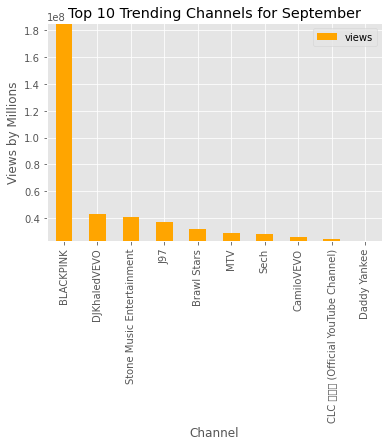

In [20]:
#Graph September
plt.style.use('ggplot')
sept_scrub.head(10).plot(kind="bar",facecolor="orange")
sept_top = sept_scrub['views'].max()
sept_bottom = sept_scrub['views'].min()
sept_x_axis = sept_scrub.index
sept_y_axis = sept_scrub['views']
plt.ylim(sept_bottom,sept_top)
plt.title("Top 10 Trending Channels for September")
plt.ylabel("Views by Millions")
plt.xlabel("Channel")

Text(0.5, 0, 'Channel')

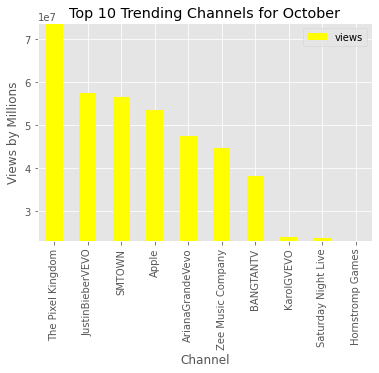

In [21]:
#Graph October
plt.style.use('ggplot')
oct_scrub.head(10).plot(kind="bar",facecolor="yellow")
oct_top = oct_scrub['views'].max()
oct_bottom = oct_scrub['views'].min()
oct_x_axis = oct_scrub.index
oct_y_axis = oct_scrub['views']
plt.ylim(oct_bottom,oct_top)
plt.title("Top 10 Trending Channels for October")
plt.ylabel("Views by Millions")
plt.xlabel("Channel")

Text(0.5, 0, 'Channel')

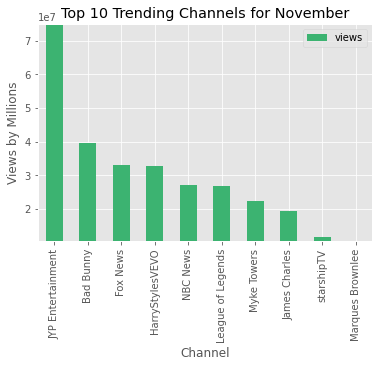

In [22]:
#Graph November
plt.style.use('ggplot')
nov_scrub.head(10).plot(kind="bar",facecolor="mediumseagreen")
nov_top = nov_scrub['views'].max()
nov_bottom = nov_scrub['views'].min()
nov_x_axis = nov_scrub.index
nov_y_axis = nov_scrub['views']
plt.ylim(nov_bottom,nov_top)
plt.title("Top 10 Trending Channels for November")
plt.ylabel("Views by Millions")
plt.xlabel("Channel")

In [23]:
#Des' Prep
#create columns of percentage of likes and dislikes
df = youtube_data

df['tot_reaction'] = df['likes'] + df['dislikes'] + df['comments']
df['tot_sentements'] = df['likes'] + df['dislikes']
df['per_likes'] = round((df['likes']/df['tot_sentements']),2)
df['per_dislikes'] = round((df['dislikes']/df['tot_sentements']), 2)
youtube_data=df  

In [24]:
#Des' Prep
#df of the top 100
df=youtube_data
df_top100=df.sort_values(by='views', ascending=False)
df_top100=df_top100.head(100)

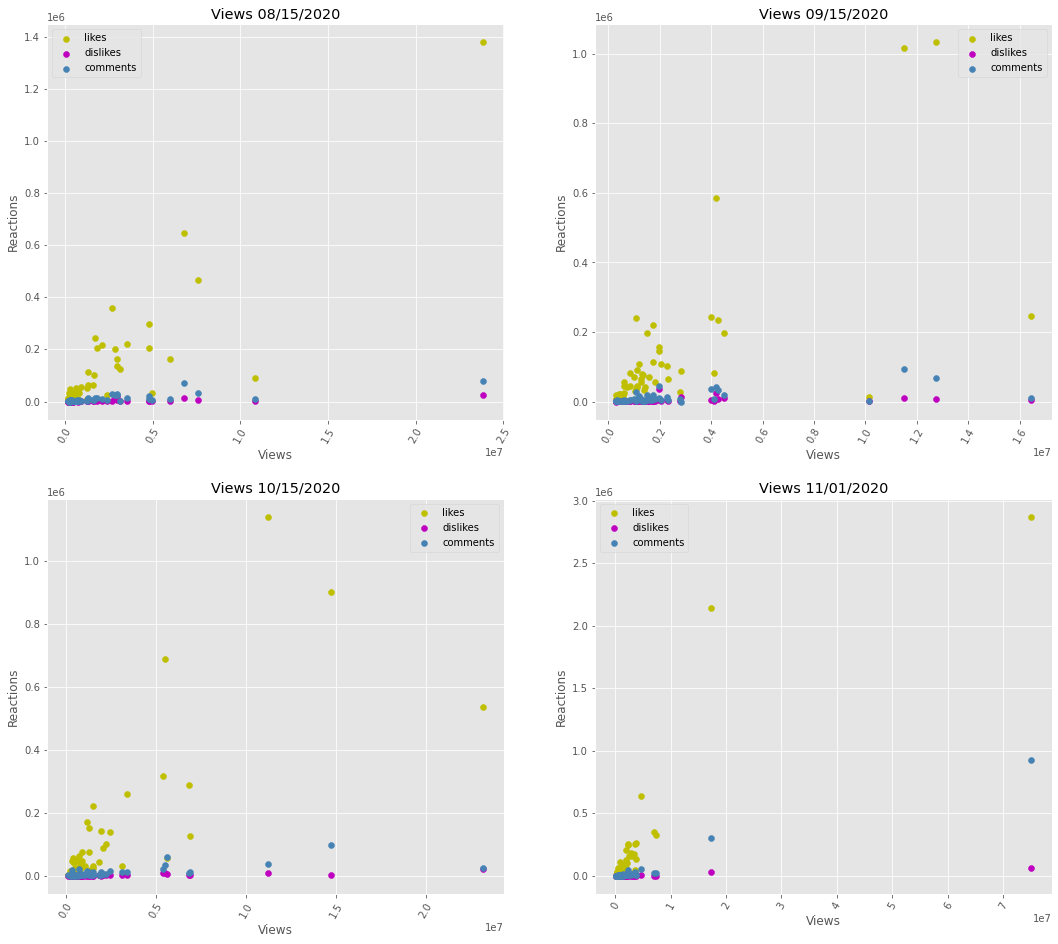

In [25]:
#Scatter Plots of likes and dislikes on a date from all four months based on views
#not 100% convinced scatter plots work for this
#August starts on the 13th, full month of Sept and Oct, Nov is only 1-5th

#input_date = input(f'Enter a date to see what was trending that day example month/day/year')
#date=df[df['date_trending']==input_date]

#subplots initilizer
fig, (ax) = plt.subplots(2, figsize=(18, 16))
plt.style.use('ggplot')

#supplot 1
#initialize
df = youtube_data
#filter by specific day
df=df[df['date_trending']=='08/15/2020']
#subplot (rows, columns, locate)
ax = plt.subplot(2, 2, 1)
ax.scatter(df['views'], df['likes'], color='y')
ax.scatter(df['views'], df['dislikes'], color='m')
ax.scatter(df['views'], df['comments'], color='steelblue')
ax.set(title='Views 08/15/2020', ylabel='Reactions', xlabel='Views')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)

#subplot 2
#initialize
df = youtube_data
#filter by specific day
df=df[df['date_trending']=='09/15/2020']
#subplot (rows, columns, locate)
ax = plt.subplot(2, 2, 2)
ax.scatter(df['views'], df['likes'], color='y')
ax.scatter(df['views'], df['dislikes'], color='m')
ax.scatter(df['views'], df['comments'], color='steelblue')
ax.set(title='Views 09/15/2020', ylabel='Reactions', xlabel='Views')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)

#subplot 3
#initialize
df = youtube_data
#filter by specific day
df=df[df['date_trending']==' 10/15/2020']
#subplot (rows, columns, locate)
ax = plt.subplot(2, 2, 3)
ax.scatter(df['views'], df['likes'], color='y')
ax.scatter(df['views'], df['dislikes'], color='m')
ax.scatter(df['views'], df['comments'], color='steelblue')
ax.set(title='Views 10/15/2020', ylabel='Reactions', xlabel='Views')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)

#subplot 4
#initialize
df = youtube_data
#filter by specific day
df=df[df['date_trending']==' 11/01/2020']
#subplot (rows, columns, locate)
ax = plt.subplot(2, 2, 4)
ax.scatter(df['views'], df['likes'], color='y')
ax.scatter(df['views'], df['dislikes'], color='m')
ax.scatter(df['views'], df['comments'], color='steelblue')
ax.set(title='Views 11/01/2020', ylabel='Reactions', xlabel='Views')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)
plt.show()

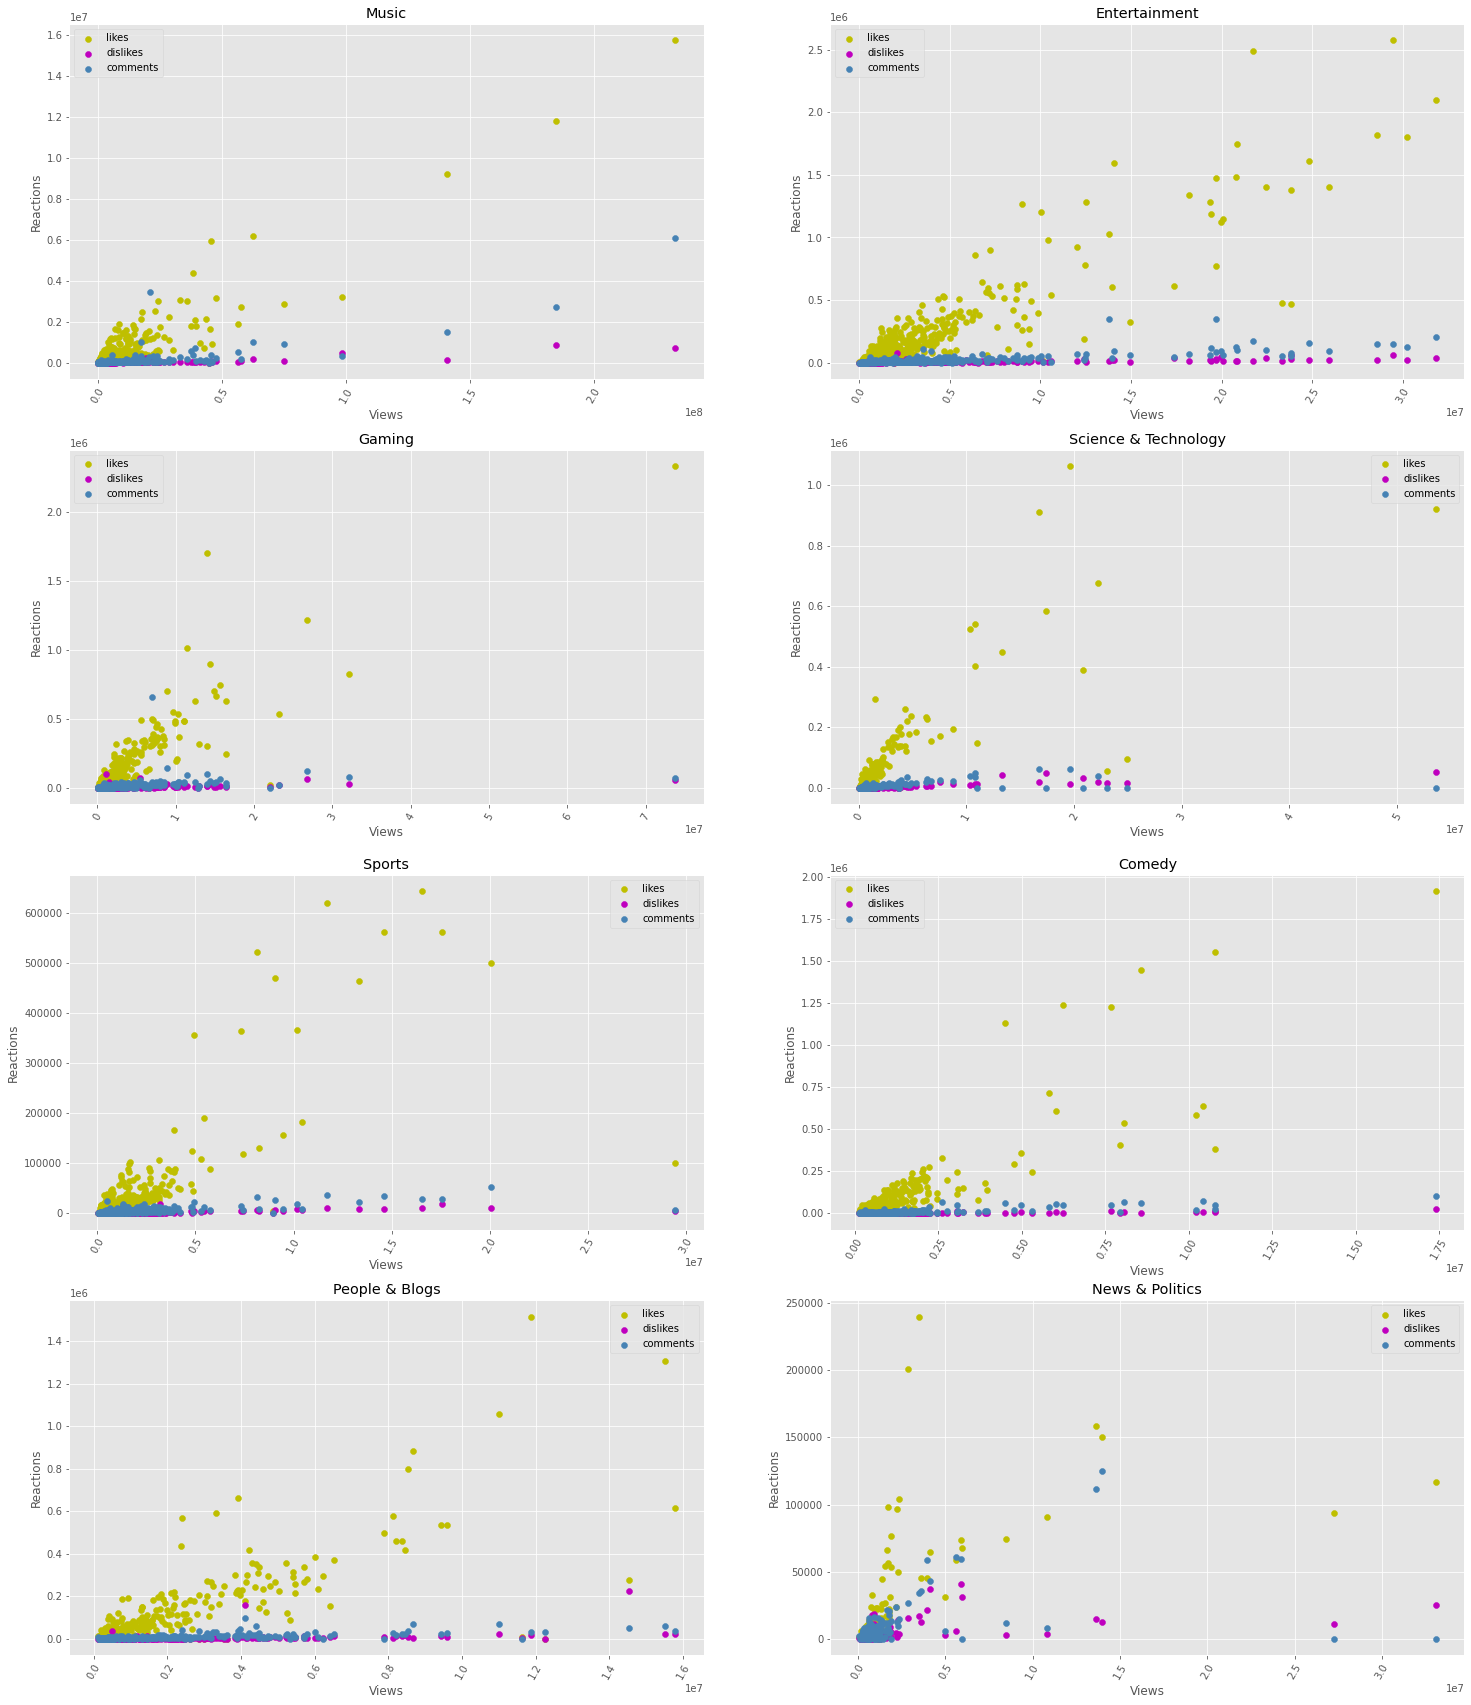

In [26]:
#scatter plots likes, dislikes and comments per category based on views
#top 8 categorys
#subplots initilizer
fig, (ax) = plt.subplots(2, figsize=(25, 30))
#format
plt.style.use('ggplot')
#supplot 1
#initialize
df = youtube_data
#filter by category
df=df[df['category']=='Music']
#subplot (rows, columns, locate)
ax = plt.subplot(4, 2, 1)
ax.scatter(df['views'], df['likes'], color='y')
ax.scatter(df['views'], df['dislikes'], color='m')
ax.scatter(df['views'], df['comments'], color='steelblue')
ax.set(title='Music',  xlabel='Views', ylabel='Reactions')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)

#subplot 2
#initialize
df = youtube_data
#filter  by category
df=df[df['category']=='Entertainment']
#subplot (rows, columns, locate)
ax = plt.subplot(4, 2, 2)
ax.scatter(df['views'], df['likes'], color='y')
ax.scatter(df['views'], df['dislikes'], color='m')
ax.scatter(df['views'], df['comments'], color='steelblue')
ax.set(title='Entertainment', xlabel='Views', ylabel='Reactions')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)

#subplot 3
#initialize
df = youtube_data
#filter by category
df=df[df['category']=='Gaming']
#subplot (rows, columns, locate)
ax = plt.subplot(4, 2, 3)
ax.scatter(df['views'], df['likes'], color='y')
ax.scatter(df['views'], df['dislikes'], color='m')
ax.scatter(df['views'], df['comments'], color='steelblue')
ax.set(title='Gaming', xlabel='Views', ylabel='Reactions')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)

#subplot 4
#initialize
df = youtube_data
#filter by category
df=df[df['category']=='Science & Technology']
#subplot (rows, columns, locate)
ax = plt.subplot(4, 2, 4)
ax.scatter(df['views'], df['likes'], color='y')
ax.scatter(df['views'], df['dislikes'], color='m')
ax.scatter(df['views'], df['comments'], color='steelblue')
ax.set(title='Science & Technology', xlabel='Views', ylabel='Reactions')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)

#subplot 5
#initialize
df = youtube_data
#filter  by category
df=df[df['category']=='Sports']
#subplot (rows, columns, locate)
ax = plt.subplot(4, 2, 5)
ax.scatter(df['views'], df['likes'], color='y')
ax.scatter(df['views'], df['dislikes'], color='m')
ax.scatter(df['views'], df['comments'], color='steelblue')
ax.set(title='Sports', xlabel='Views', ylabel='Reactions')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)

#subplot 6
#initialize
df = youtube_data
#filter by category
df=df[df['category']=='Comedy']
#subplot (rows, columns, locate)
ax = plt.subplot(4, 2, 6)
ax.scatter(df['views'], df['likes'], color='y')
ax.scatter(df['views'], df['dislikes'], color='m')
ax.scatter(df['views'], df['comments'], color='steelblue')
ax.set(title='Comedy', xlabel='Views', ylabel='Reactions')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)

#subplot 7
#initialize
df = youtube_data
#filter by category
df=df[df['category']=='People & Blogs']
#subplot (rows, columns, locate)
ax = plt.subplot(4, 2, 7)
ax.scatter(df['views'], df['likes'], color='y')
ax.scatter(df['views'], df['dislikes'], color='m')
ax.scatter(df['views'], df['comments'], color='steelblue')
ax.set(title='People & Blogs', xlabel='Views', ylabel='Reactions')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)

#subplot 8
#initialize
df = youtube_data
#filter by category
df=df[df['category']=='News & Politics']
#subplot (rows, columns, locate)
ax = plt.subplot(4, 2, 8)
ax.scatter(df['views'], df['likes'], color='y')
ax.scatter(df['views'], df['dislikes'], color='m')
ax.scatter(df['views'], df['comments'], color='steelblue')
ax.set(title='News & Politics', xlabel='Views', ylabel='Reactions')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)
plt.show()

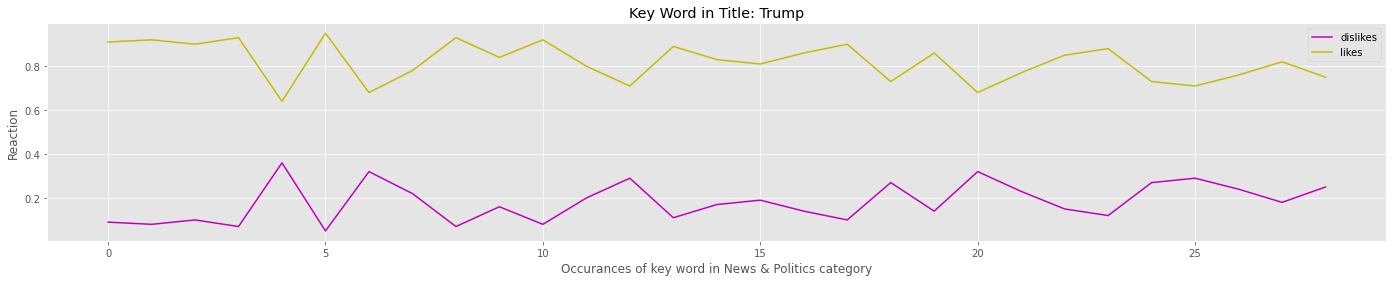

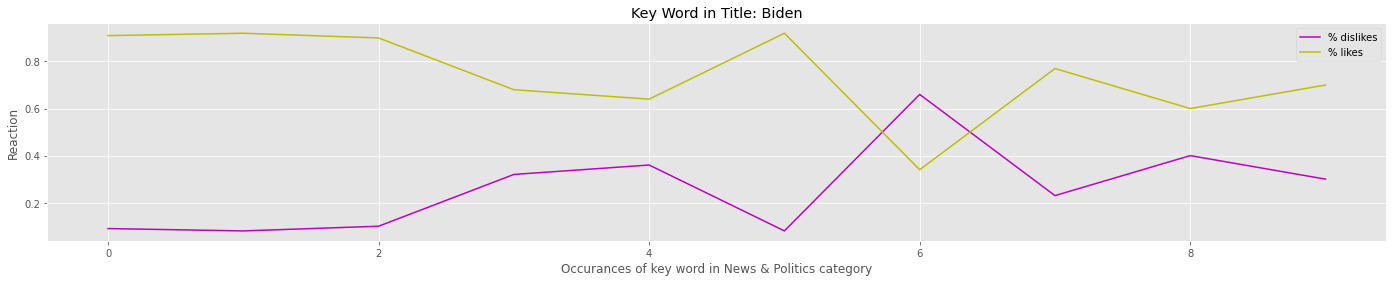

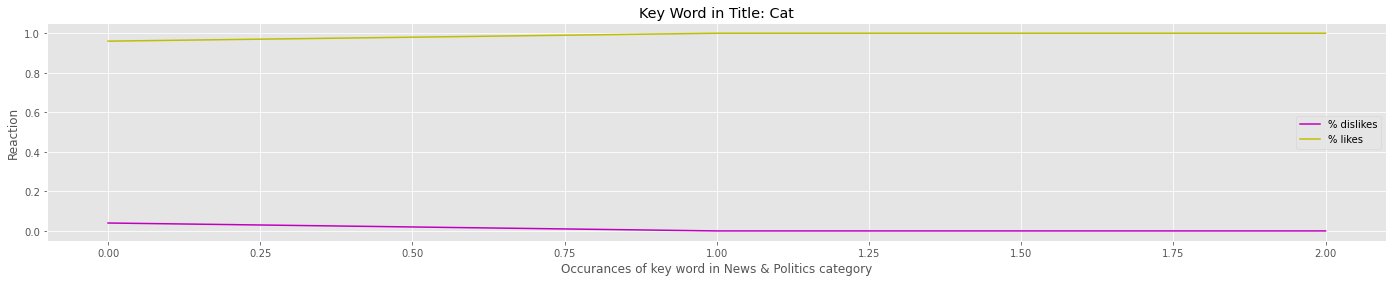

In [27]:
#Discord analsys: Shows reactions based on percet likes/dislikes if key term found in titles 
#subplots initilizer
fig, (ax) = plt.subplots(1, figsize=(24, 4))
#format
plt.style.use('ggplot')
#subplot 1
#initialize
df = youtube_data
#category filter
df=df[df['category']=='News & Politics']
#title filter: searches for key words in titles
df=df[df['title'].apply(lambda x : re.search('trump',x.lower()) !=None)]
#subplot x= 0 to lenght of dataframe, y= percent of like or dislike
ax.plot(range(len(df)), df['per_dislikes'], c='m')
ax.plot(range(len(df)), df['per_likes'], c='y')
ax.legend(['dislikes', 'likes'])
ax.set(title='Key Word in Title: Trump', ylabel='Reaction', xlabel='Occurances of key word in News & Politics category')

#subplots initilizer
fig, (ax) = plt.subplots(1, figsize=(24, 4))
#subplot 2
#initialize
df = youtube_data
#category filter
df=df[df['category']=='News & Politics']
#title filter: searches for key words in titles
df=df[df['title'].apply(lambda x : re.search('biden',x.lower()) !=None)]
#subplot x= 0 to lenght of dataframe, y= percent of like or dislike
ax.plot(range(len(df)), df['per_dislikes'], c='m')
ax.plot(range(len(df)), df['per_likes'], c='y')
ax.legend(['% dislikes', '% likes'])
ax.set(title='Key Word in Title: Biden', ylabel='Reaction', xlabel='Occurances of key word in News & Politics category')

#subplots initilizer
fig, (ax) = plt.subplots(1, figsize=(24, 4))
#subplot 2
#initialize
df = youtube_data
#category filter
df=df[df['category']=='People & Blogs']
#title filter: searches for key words in titles
df=df[df['title'].apply(lambda x : re.search('cat',x.lower()) !=None)]
#subplot x= 0 to lenght of dataframe, y= percent of like or dislike
ax.plot(range(len(df)), df['per_dislikes'], c='m')
ax.plot(range(len(df)), df['per_likes'], c='y')
ax.legend(['% dislikes', '% likes'])
ax.set(title='Key Word in Title: Cat', ylabel='Reaction', xlabel='Occurances of key word in News & Politics category')

plt.show()

#User input key term search to see percentage likes and dislikes for a key term
#subplots initilizer
fig, (ax) = plt.subplots(1, figsize=(24, 4))
#format
plt.style.use('ggplot')
#subplot 2
#initialize
df = youtube_data
#category filter
#title filter: searches for key words in titles user input
input_term = input(f'Enter a term to view percentage of likes and dislikes ')

df=df[df['title'].apply(lambda x : re.search(input_term,x.lower()) !=None)]
#subplot
ax.plot(range(len(df)), df['per_dislikes'], c='g')
ax.plot(range(len(df)), df['per_likes'], c='m')
ax.legend(['dislikes', 'likes'])
ax.set(title=f'Key Word in Title: {input_term}') 
ax.set(ylabel='Reaction', xlabel='Occurances of key word in titles')
plt.show()

df_top100
df['tot_reaction'] 
df['tot_sentements']  

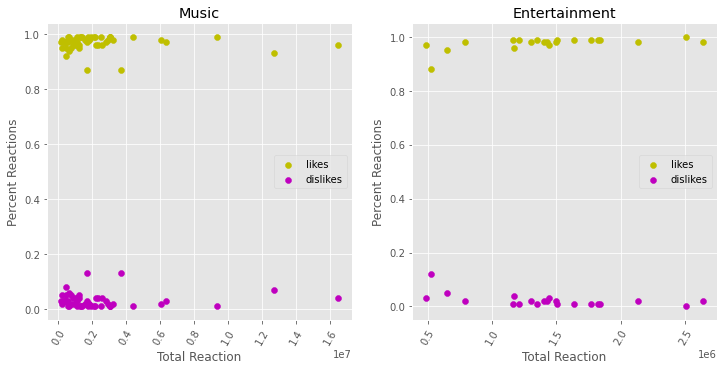

In [28]:
#Scatter of percent of likes and dislikes by catagory
#subplots initilizer
fig, (ax) = plt.subplots(1, figsize=(12, 12))
#format
plt.style.use('ggplot')
#initialize
df = youtube_data
df = df_top100 
cat = 'Music' #filter by category
df=df[df['category']==cat ] 
ax = plt.subplot(2, 2, 1) #subplot (rows, columns, locate)
ax.scatter(df['tot_sentements'], df['per_likes'], color='y') 
ax.scatter(df['tot_sentements'], df['per_dislikes'], color='m') 
ax.set(title=f'{cat}', xlabel='Total Reaction', ylabel='Percent Reactions')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)

df = df_top100 
cat = 'Entertainment' #filter by category
df=df[df['category']==cat ] 
ax = plt.subplot(2, 2, 2) #subplot (rows, columns, locate)
ax.scatter(df['tot_sentements'], df['per_likes'], color='y') 
ax.scatter(df['tot_sentements'], df['per_dislikes'], color='m') 
ax.set(title=f'{cat}', xlabel='Total Reaction', ylabel='Percent Reactions')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)
plt.show()

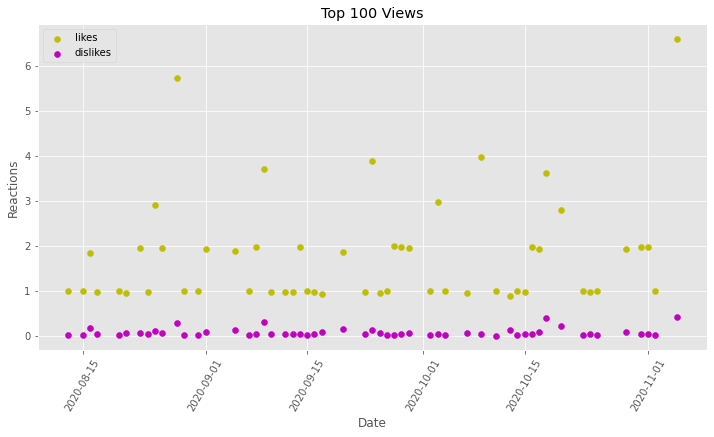

In [29]:
#Scatter of reactions of top 100 views and percent of likes and dislikes
#subplots initilizer
fig, (ax) = plt.subplots(1, figsize=(12, 6))
#format
plt.style.use('ggplot')
#initialize, group by date
df = df_top100.groupby('date_trending').sum() 
#subplot
ax = plt.subplot(1, 1, 1) #subplot (rows, columns, locate)
ax.scatter(df.index, df['per_likes'], color='y') 
ax.scatter(df.index, df['per_dislikes'], color='m')  
#labels
ax.set(title='Top 100 Views', xlabel='Date', ylabel='Reactions')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)
plt.show()

In [30]:
#export clean data
youtube_data.to_csv("youtube_data.csv", index=False, header=True)

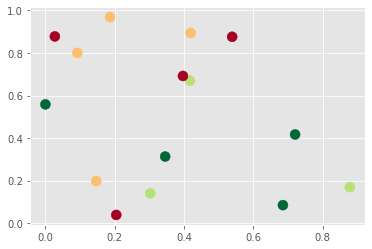

In [31]:
df = df_top100.head(15)
x = np.random.rand(15)
y = np.random.rand(15)
names = np.array(list("ABCDEFGHIJKLMNO"))
c = np.random.randint(1,5,size=15)

norm = plt.Normalize(1,4)
cmap = plt.cm.RdYlGn

fig,ax = plt.subplots()
sc = plt.scatter(x,y,c=c, s=100, cmap=cmap, norm=norm)

annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

def update_annot(ind):

    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}, {}".format(" ".join(list(map(str,ind["ind"]))), 
                           " ".join([names[n] for n in ind["ind"]]))
    annot.set_text(text)
    annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
    annot.get_bbox_patch().set_alpha(0.4)


def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)

plt.show()